# Практика №2

На прошлой практике мы реализовали DTW алгоритм. Он очень хорош и вроде как даже где-то применяется. Но у него есть существенные недостатки:

1) Для распознавания какого-либо слова необходимо иметь заранее подготовленные эталонные записи. Из этого вытекает проблема масштабирования системы с большим словарем.<br>
2) Подобная система имеет плохую устойчивость к шумам.<br>
3) По какому принципу вибирать нужные эталоны?<br>
4) Сколько должно быть таких эталонов, чтобы покрыть всю вариативность произнесеней?<br>
5) Чем больше эталонов, тем алгоритм вычислительнозатратен.<br>

В этом уроке мы перейдем от DTW к распознаванию по эталонному словарю. 

Эталон в графе теперь будет задаваться как последовательность фонем из словаря. Словарь для YES_NO (data/lexicon_yes_no.txt) выглядит следующим образом:

<b>YES</b>  SIL Y EH1 S SIL<br>
<b>NO</b>  SIL N OW1 SIL<br>

Словарь для цифр (data/lexicon_digits.txt):

<b>ZERO</b>  SIL Z IH1 R OW0 SIL<br>
<b>ZERO</b>  SIL Z IY1 R OW0 SIL<br>
<b>ONE</b>  SIL W AH1 N SIL<br>
<b>ONE</b>  SIL HH W AH1 N SIL<br>
<b>TWO</b>  SIL T UW1 SIL<br>
<b>THREE</b>  SIL TH R IY1 SIL<br>
<b>FOUR</b>  SIL F AO1 R SIL<br>
<b>FIVE</b>  SIL F AY1 V SIL<br>
<b>SIX</b>  SIL S IH1 K S SIL<br>
<b>SEVEN</b>  SIL S EH1 V AH0 N SIL<br>
<b>EIGHT</b>  SIL EY1 T SIL<br>
<b>NINE</b>  SIL N AY1 N SIL<br>

SIL здесь – это фонема паузы.
Как вы возможно заметили, для некторых слов имеется несколько вариантов фонемной транскрипции. Это позволяет лучше учесть фонетическое разнообразие в произнесении некоторых слов.

Каждой фонеме будет сопоставлен наиболее типичный для нее вектор признаков. В данном случае мы будем использовать среднее значение вектора признаков фонем, взятых из обучающего набора. Будем называть это акустической моделью.

### Данные для обучения

Наша задача собрать статистику акустических признаков по каждой фонеме, находящейся в графе распознавания. В качестве обучающей выборки мы будем использовать подмножество данных librispeech (аудиозаписи чтения книг на английском). Для этого предварительно мной была получена покадровая разметка этого подмножества на фонемы. Схематично данный процесс представлен на картинке ниже:

![](https://drive.google.com/uc?export=view&id=16PdwggV_Cl6aaD4cu1MZ-fKzWzAvcFVw)

Файл разметки (ali_phones.txt) представлен в формате:

<b>filename1 phone_frame1 phone_frame2 phone_frame3 ...<br>
   filename2 phone_frame1 phone_frame2 phone_frame3 ...</b> 
   
Пример такой покадровой фонемной разметки одного файла с текстом "<b>MUCH COULD BE DONE IN THREE YEARS</b>" представлен ниже:

<b>1183-124566-0003 SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL M M M M M M M M M AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 CH CH CH CH CH CH CH CH CH CH CH K K K K
K K K K K UH1 UH1 UH1 UH1 D D D D D B B B B B B IY0 IY0 IY0 IY0 IY0 D D D D D D D D D D D D AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 AH1 N N
N N N N N N N N N N N N N SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SIL SI
L SIL SIL SIL SIL SIL SIL SIL SIL IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 N N N N N N N N N N SIL SIL SIL SIL SIL TH TH TH TH TH TH TH TH TH TH TH TH TH R R R R R R IY1 IY1
 IY1 IY1 IY1 IY1 IY1 Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y IH1 IH1 IH1 IH1 IH1 IH1 IH1 IH1 R R R R R R R R R R R R R R R Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z SIL SIL SIL SIL</b>
 
Аудио файлы этих данных лежат в папке "data/train_librispeech_10h/wav_dir"

### Bootstrap

In [ ]:
# !pip install --upgrade --no-cache-dir gdown

# !gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
# !gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 116MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
100% 679M/679M [00:09<00:00, 72.8MB/s]


In [ ]:
# !unzip -q lab2.zip
# !unzip -q train_librispeech_10h.zip
# !mv train_librispeech_10h lab2/data
# !rm -rf lab2.zip sample_data train_librispeech_10h.zip
# %cd lab2

/content/lab2


In [1]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display



%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# рассмотрим пример такой записи:
wav_example = 'data/train_librispeech_10h/wav_dir/1183-124566-0003.flac'

# чтение wav файла:
x, sr = librosa.load(wav_example, sr=None)     # sr=None to preserve the native sampling rate

print(f'Number of samples: {len(x)}')
print(f'Sampling rate: {sr} Hz')
print(f'Duration: {len(x)/sr:.2f} s')  # ~ librosa.get_duration(x, sr)

# воспроизведение:
ipd.Audio(x, rate=sr)

Number of samples: 45680
Sampling rate: 16000 Hz
Duration: 2.85 s


Text(0.5, 1.0, 'Log-frequency power spectrogram')

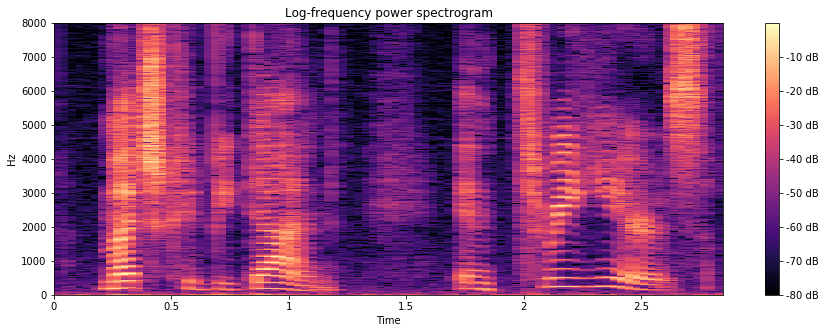

In [3]:
# спектрограмма:
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
plt.figure(figsize=(15,5))
librosa.display.specshow(D, sr=sr, y_axis='hz', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

### Подготовка данных

In [4]:
# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)  # {имя_файла: список произнесенных фонем}

In [5]:
# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    for step, wav_name in tqdm(enumerate(os.listdir(dir_path))):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(y=x,
                                    sr=sr,
                                    n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict

train_records_dir = 'data/train_librispeech_10h/wav_dir'
train_data_dict = load_data_dict(train_records_dir, count=100)    # {имя_файла: mfcc-признаки}

0it [00:00, ?it/s]

Early stop at 100th file..


In [6]:
# инициализация списка допустимых фонем из предустановленного файла
def init_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for line in fn:
            phones_dict[line.strip()] = []
    return phones_dict

phones_file = 'data/train_librispeech_10h/phones'
phones_dict = init_phones_dict(phones_file)     # {фонема: []}

In [7]:
# присвоим каждой фонеме набор ее признаков в соответствии с фонемной разметкой обучающей выборки
# количество кадров признаков может немного отличаться от количества размеченных фонем
# это связано с особенностми построения разметки в Kaldi
for file_name in train_data_dict.keys():
    file_feats = train_data_dict[file_name]  # mfcc-признаки
    file_ali = ali_dict[file_name]    # список произнесенных фонем
    for frame in range(min(len(file_feats), len(file_ali))):
        phones_dict[file_ali[frame]].append(file_feats[frame])   # разметка {фонема: mfcc-признаки} 
        
# выведем статистику по кадой фонеме (некоторые фонемы вообще не используются, это особенности разметки в Kaldi):
count = 0
for phone in phones_dict.keys():
    if len(phones_dict[phone]) == 0:
        count +=1
    print(f'{phone:<3}: {len(phones_dict[phone])}')
print(f'Number of empty phones is: {count}')

SIL: 22667
SPN: 644
AA : 0
AA0: 39
AA1: 1591
AA2: 87
AE : 0
AE0: 14
AE1: 3867
AE2: 30
AH : 0
AH0: 5611
AH1: 2262
AH2: 55
AO : 0
AO0: 24
AO1: 1811
AO2: 19
AW : 0
AW0: 0
AW1: 1031
AW2: 17
AY : 0
AY0: 30
AY1: 2597
AY2: 253
B  : 1374
CH : 784
D  : 3939
DH : 1945
EH : 0
EH0: 20
EH1: 2770
EH2: 97
ER : 0
ER0: 2504
ER1: 1066
ER2: 5
EY : 0
EY0: 12
EY1: 2243
EY2: 186
F  : 2466
G  : 665
HH : 2007
IH : 0
IH0: 2744
IH1: 2307
IH2: 113
IY : 0
IY0: 2545
IY1: 2092
IY2: 39
JH : 418
K  : 2961
L  : 4672
M  : 2864
N  : 6105
NG : 1470
OW : 0
OW0: 160
OW1: 1948
OW2: 85
OY : 0
OY0: 0
OY1: 227
OY2: 0
P  : 2127
R  : 4107
S  : 6637
SH : 1235
T  : 6554
TH : 907
UH : 0
UH0: 7
UH1: 448
UH2: 4
UW : 0
UW0: 53
UW1: 1511
UW2: 57
V  : 1778
W  : 2359
Y  : 709
Z  : 3123
ZH : 37
Number of empty phones is: 18


In [8]:
# соберем статистику на основе среднего значения для каждой фонемы
mean_phones_value = {}
for phone in phones_dict.keys():
    if phones_dict[phone]:
        mean_phones_value[phone] = np.mean(phones_dict[phone], axis=0)

In [9]:
from sklearn.mixture import GaussianMixture

In [10]:
#-----------------------------TODO №2-----------------------------------
# построить GMM модель для каждой фонемы (смотри задание2)

# смотреть задание 2
#-----------------------------------------------------------------------

### Инициализация фонемного графа

In [11]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)

In [12]:
lexicon_dict

{'YES': ['SIL', 'Y', 'EH1', 'S', 'SIL'], 'NO': ['SIL', 'N', 'OW1', 'SIL']}

Узлы графа теперь представляют собой отдельные фонемы с переходом только в себя и следующий узел (переходов через несколько узлов уже не будет, так как пропуск фонемы в слове нежелателен). Схема такого графа для да/нет (для цифр по аналогии) представлена ниже:

![](https://drive.google.com/uc?export=view&id=1IJhR0l0YCPDge05ohigs0_P5gDX66fdM)

В качестве <b>model</b> мы будем хранить простой класс <b>AcousticModel</b>, который хранит в себе имя фонемы и ее среднее значение. Также у этого класса есть метод вычисления евклидовой дистанции от хранящегося в нем среднего значения признака фонемы до текущего признака распознаваемой записи, который передается этому методу. 

In [13]:
class AcousticModel:
    def __init__(self, phone_name, phone_feats):
        self.phone_name = phone_name
        self.phone_feats = phone_feats
    def distance(self, input_feats):
        return float(np.sqrt(sum(pow(self.phone_feats - input_feats, 2))))

#-----------------------------TODO №2--------------------------------------------
# заменить акустическую модель на основе среднего значения признака на GMM модель
class GmmAcousticModel:
    pass
# смотреть задание 2
#--------------------------------------------------------------------------------

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, mean_phones_value):
    start_state = State(AcousticModel(None, None), 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, mean_phones_value[phone]), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph


def print_graph(graph):
    if not os.path.exists('exp'):
        os.mkdir('exp')
    with open('exp/graph.txt', 'w') as fn:
        np.set_printoptions(formatter={'float': '{: 0.1f}'.format})
        for state in graph:
            next_state_indexes = [s.index for s in state.next_states]
            fn.write("State: index={} word={} is_final={} next_state_indexes={} phone={} \n".format(
                state.index, state.word, state.is_final, next_state_indexes, state.model.phone_name))
    print("*** SEE exp/graph.txt ***")

In [14]:
graph = load_graph(lexicon_dict, mean_phones_value)
print_graph(graph)

*** SEE exp/graph.txt ***


In [15]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    best_token = next_tokens[np.argmin([token.dist for token in next_tokens])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for token in next_tokens:  
        if not token.state.best_token:
            token.state.best_token = token
        else:
            if token.dist <= token.state.best_token.dist:
                token.state.best_token.alive = False
                token.state.best_token = token
            else:
                token.alive = False              
    # сбрасываем best_token на None для всеx узлов графа:
    for token in next_tokens:                                                   
        if token.state.best_token:                     
            token.state.best_token = None              
    return next_tokens


def recognize(filename, features, graph, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []

    #for ftr_frame in tqdm(features, desc="recognition..."):
    for ftr_frame in features:
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [16]:
def run_recognizer(records_data_dict, graph, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename, records_data_dict[filename], graph, recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

In [17]:
def load_data_dict(dir_path):
    data_dict = {}
    for wav_name in os.listdir(dir_path):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        data_dict[wav_name] = mfcc.T
    
    return data_dict

### Запустим наше распознавание на базе YES_NO

In [18]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

run_recognizer(records_data_dict, graph, beam_threshold=10)

result: no_ad89eb1e_nohash_0.wav    ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: yes_39a6b995_nohash_0.wav   ==> NO
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: no_4abb2400_nohash_0.wav    ==> NO
result: yes_fe1916ba_nohash_0.wav   ==> NO
result: no_41474817_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: no_4394fc7c_nohash_0.wav    ==> NO
------------------------------------------------------------
WER is: 20.00%
Total time is: 0.05 sec
------------------------------------------------------------


### Запустим наше распознавание на базе Digits

In [19]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, mean_phones_value)
records_data_dict = load_data_dict("lab2/data/digits/records")

run_recognizer(records_data_dict, graph, beam_threshold=300)

result: one_ffa76c4a_nohash_0.wav   ==> ONE
result: two_fce65496_nohash_0.wav   ==> NINE
result: seven_fd32732a_nohash_0.wav ==> SIX
result: eight_da584bc0_nohash_4.wav ==> SEVEN
result: nine_fbe51750_nohash_0.wav  ==> ONE
result: four_ffbb695d_nohash_0.wav  ==> FOUR
result: four_fce65496_nohash_0.wav  ==> ONE
result: five_f852895b_nohash_0.wav  ==> THREE
result: one_fc2411fe_nohash_0.wav   ==> ONE
result: six_ffbb695d_nohash_0.wav   ==> SIX
result: eight_daf230ac_nohash_0.wav ==> THREE
result: five_ffd2ba2f_nohash_0.wav  ==> FIVE
result: three_feb1d305_nohash_0.wav ==> SIX
result: six_ffd2ba2f_nohash_0.wav   ==> SIX
result: zero_f92e49f3_nohash_3.wav  ==> SEVEN
result: nine_ccea893d_nohash_0.wav  ==> NINE
result: zero_f852895b_nohash_0.wav  ==> TWO
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: seven_fe5c4a7a_nohash_0.wav ==> FOUR
result: three_fce96bac_nohash_0.wav ==> FIVE
------------------------------------------------------------
WER is: 60.00%
Total time is: 0.51 sec
------

### <b>Задание №1</b> (5 баллов):
Отрисовать кластеры признаков фонем "Y EH1 S N OW1" в двухмерном пространстве. Для понижения размерности можно воспользоваться алгоритмом t-SNE -- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html. Все пять кластеров должны помещаться на один рисунок и иметь разные цвета. Также укажите на графике какой цвет какой фонеме соответствует.  

In [20]:
from sklearn.manifold import TSNE

In [21]:
labels = ['Y', 'EH1', 'S', 'N', 'OW1']
colors = {'Y': 'y',
          'EH1': 'b',
          'S': 'g',
          'N': 'm',
          'OW1': 'r'}


def tsne_transform(phones_dict):
    features_matrix = []
    phones = []
    for i, phone in enumerate(['Y', 'EH1', 'S', 'N', 'OW1']):
        features_matrix.extend(phones_dict[phone])
        phones.extend([phone] * len(phones_dict[phone]))
    features_matrix = np.array(features_matrix)   
    print(f'features_matrix.shape = {features_matrix.shape}, len(phones) = {len(phones)}')
    X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=42).fit_transform(features_matrix)
    return X_tsne, phones


def scatter_plot(X_tsne, phones, labels, colors):
    fig, ax = plt.subplots(figsize=(12, 8))
    #plt.figure(figsize=(12, 80))
    for label in labels:
        #print(phone)
        #print(labels.index(phone))
        ix = np.where(phones == label)[0]
        ax.scatter(X_tsne[:,0][ix], X_tsne[:,1][ix], c = colors[label], label=label, alpha=0.7)
    ax.legend()
    plt.show()





features_matrix.shape = (18169, 13), len(phones) = 18169


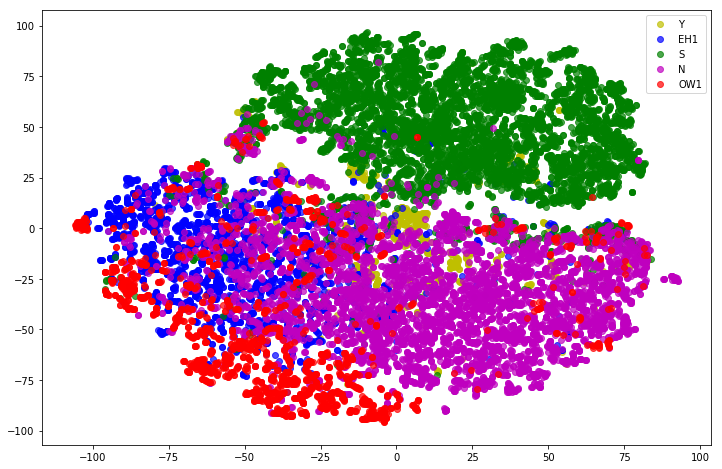

In [22]:
X_tsne, phones = tsne_transform(phones_dict)
scatter_plot(X_tsne, np.array(phones), labels, colors)

Четко визуализируются кластеры для фонем `S`, `N`, `EH1`. Размазанными оказались фонемы для `Y` и `OW1`

Соберем векторы признаков по-другому. Будем выкидывать `n` первых и последних признаков при смене фонемы.

In [23]:
# присвоим каждой фонеме набор ее признаков в соответствии с фонемной разметкой обучающей выборки
# количество кадров признаков может немного отличаться от количества размеченных фонем
# это связано с особенностми построения разметки в Kaldi
def generate_new_phones_dict(n, treshold):
    phones_dict_new = {'Y': [],
                      'EH1': [],
                      'S': [],
                      'N': [],
                      'OW1': []}


    for file_name in train_data_dict.keys():
        file_feats = train_data_dict[file_name]  # mfcc-признаки
        file_ali = ali_dict[file_name]    # список произнесенных фонем
        cur_phones = file_ali[: n]
        for frame in range(min(len(file_feats), len(file_ali))):
            phone = file_ali[frame]
            #print(phone)
            # в окрестности (frame - n; frame + n) только фонема file_ali[frame]
            if (phone in phones_dict_new) and (set(file_ali[max(0, frame - n): frame + n + 1]) == {phone}):
                if len(phones_dict_new[file_ali[frame]]) >= treshold:
                    continue
                phones_dict_new[file_ali[frame]].append(file_feats[frame])   # разметка {фонема: mfcc-признаки} 
    return phones_dict_new

Для n = 3, порога = inf:
features_matrix.shape = (7236, 13), len(phones) = 7236


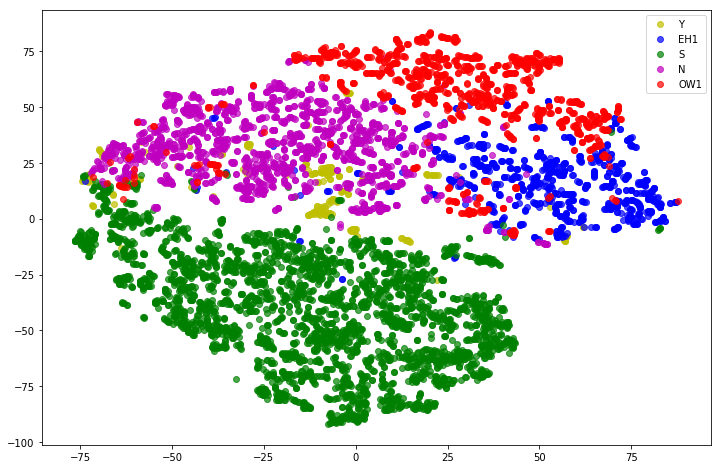

In [24]:
n = 3
treshold = np.inf
print(f'Для n = {n}, порога = {treshold}:')
phones_dict_new = generate_new_phones_dict(n=n, treshold=treshold)
X_tsne_new, phones_new = tsne_transform(phones_dict_new)
scatter_plot(X_tsne_new, np.array(phones_new), labels, colors)

Для n = 4, порога = inf:
features_matrix.shape = (4906, 13), len(phones) = 4906


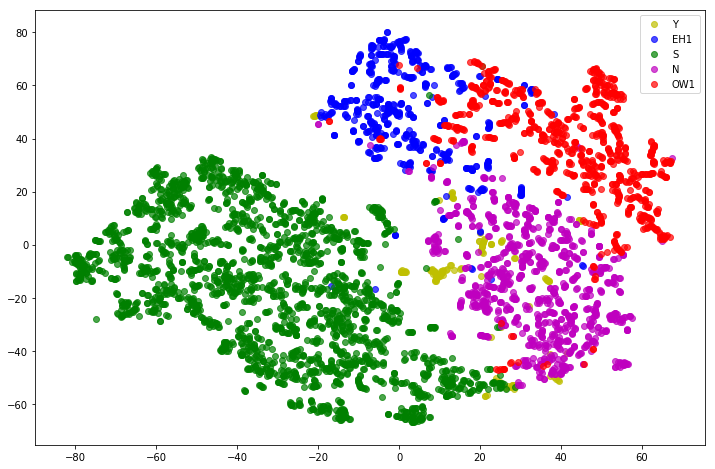

In [25]:
n = 4
treshold = np.inf
print(f'Для n = {n}, порога = {treshold}:')
phones_dict_new = generate_new_phones_dict(n=n, treshold=treshold)
X_tsne_new, phones_new = tsne_transform(phones_dict_new)
scatter_plot(X_tsne_new, np.array(phones_new), labels, colors)

Фонемы `OW1` уже почти отделились, но фонемы для `Y` все так же размазаны

Начнем менять значение порога

Для n = 3, порога = 50:
features_matrix.shape = (250, 13), len(phones) = 250


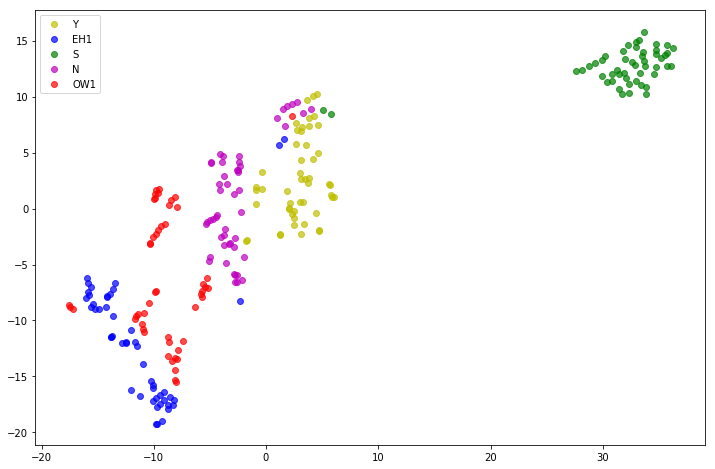

In [26]:
n = 3
treshold = 50
print(f'Для n = {n}, порога = {treshold}:')
phones_dict_new = generate_new_phones_dict(n=n, treshold=treshold)
X_tsne_new, phones_new = tsne_transform(phones_dict_new)
scatter_plot(X_tsne_new, np.array(phones_new), labels, colors)

Для n = 6, порога = 60:
features_matrix.shape = (283, 13), len(phones) = 283


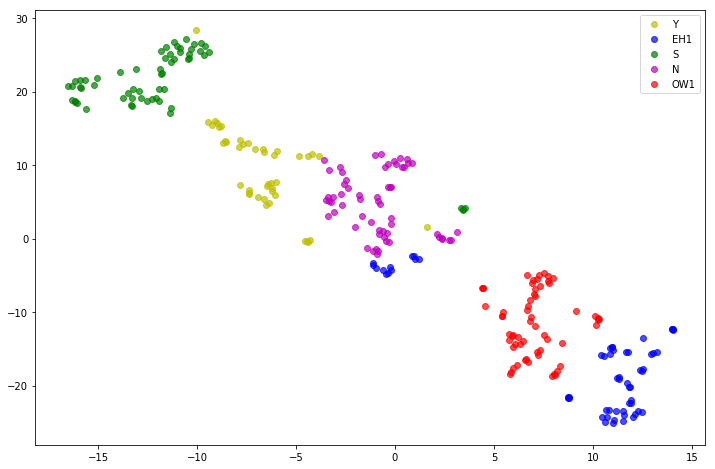

In [27]:
n = 6
treshold = 60
print(f'Для n = {n}, порога = {treshold}:')
phones_dict_new = generate_new_phones_dict(n=n, treshold=treshold)
X_tsne_new, phones_new = tsne_transform(phones_dict_new)
scatter_plot(X_tsne_new, np.array(phones_new), labels, colors)

В каждом кластере не одинаковое число точек, но зато при таких параметрах точки почти хорошо разделились.

### **Ответ**:

Для преобразования были выбраны только указанные фонемы и их mfcc-признаки. Оказалось, что хорошо визуализируются кластеры для фонем `S`, `N` и `EH1`, а кластеры для фонем `Y` и `OW1` размазались по картинке. 

Для улучшения представления будем брать mfcc-признак для фонемы, если в некоторой окрестности радиуса `n` будет эта же фонема (убираем переходное произношение). Еще введем порог на количество точек (сколько признаков берем).  
При переборе значений для `n` и порога получаем, что оптимальные значения `n = 6`, `порог = 60`. Хоть в кластерах разное число точек, но зато облака точек получились разделимы.

Разбиение на кластеры для n = 6, порог = 60


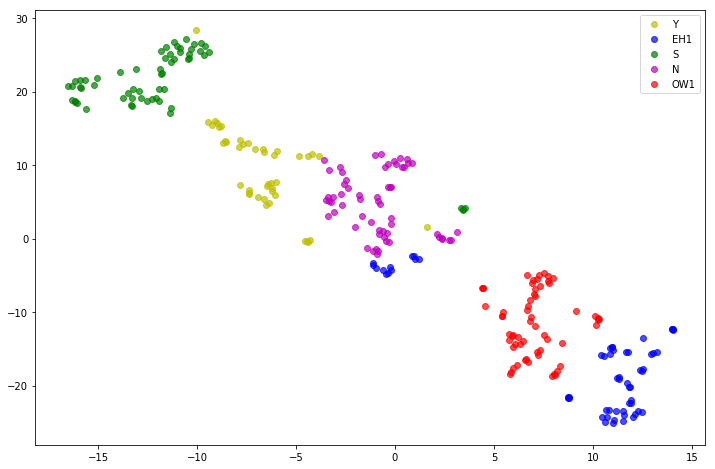

In [28]:
print("Разбиение на кластеры для n = 6, порог = 60")
scatter_plot(X_tsne_new, np.array(phones_new), labels, colors)

### <b>Задание №2</b> (5 баллов):
Заменить модель среднего значения фонемы на GMM. Количестов смесей для каждой фонемы можно выставить в 3. Теперь вместо расстояния мы будем измерять вероятность принадлежности кадра признаков к GMM модели фонемы, находящейся в конкретном узле графа. Чтобы использовать это значение в парадигме нашего алгоритма, в качестве дистанции нужно брать значение -log(x), где x -- предсказанная вероятность. Тогда чем выше вероятность, тем такая импровизированная дистанция будет меньше. Ссылка на питоновскую реализацию GMM -- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html.

Что стало с качеством распознавания на двух тестах?

In [29]:
#-----------------------------TODO №2-----------------------------------
# построить GMM модель для каждой фонемы (смотри задание2)
n_components = 4
gmm_phones_value = {}
for phone in phones_dict.keys():
    X = phones_dict[phone]
    if X:
        gm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=1000, random_state=42)
        gm.fit(X)
        gmm_phones_value[phone] = gm
#-----------------------------------------------------------------------

In [30]:
#-----------------------------TODO №2--------------------------------------------
# заменить акустическую модель на основе среднего значения признака на GMM модель
class GmmAcousticModel:
    def __init__(self, phone_name, phone_feats):
        self.phone_name = phone_name
        self.phone_feats = phone_feats
    def distance(self, input_feats):
        return -self.phone_feats.score([input_feats])
#--------------------------------------------------------------------------------

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, gmm_phones_value):
    start_state = State(GmmAcousticModel(None, None), 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(GmmAcousticModel(phone, gmm_phones_value[phone]), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph


def print_graph(graph):
    if not os.path.exists('exp'):
        os.mkdir('exp')
    with open('exp/graph.txt', 'w') as fn:
        np.set_printoptions(formatter={'float': '{: 0.1f}'.format})
        for state in graph:
            next_state_indexes = [s.index for s in state.next_states]
            fn.write("State: index={} word={} is_final={} next_state_indexes={} phone={} \n".format(
                state.index, state.word, state.is_final, next_state_indexes, state.model.phone_name))
    print("*** SEE exp/graph.txt ***")

In [31]:
graph = load_graph(lexicon_dict, gmm_phones_value)
print_graph(graph)

*** SEE exp/graph.txt ***


In [32]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

run_recognizer(records_data_dict, graph, beam_threshold=61)

result: no_ad89eb1e_nohash_0.wav    ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: yes_39a6b995_nohash_0.wav   ==> YES
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: no_4abb2400_nohash_0.wav    ==> NO
result: yes_fe1916ba_nohash_0.wav   ==> YES
result: no_41474817_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: no_4394fc7c_nohash_0.wav    ==> NO
------------------------------------------------------------
WER is: 0.00%
Total time is: 1.46 sec
------------------------------------------------------------


In [33]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value)
records_data_dict = load_data_dict("lab2/data/digits/records")

run_recognizer(records_data_dict, graph, beam_threshold=50)

result: one_ffa76c4a_nohash_0.wav   ==> ONE
result: two_fce65496_nohash_0.wav   ==> NINE
result: seven_fd32732a_nohash_0.wav ==> SEVEN
result: eight_da584bc0_nohash_4.wav ==> EIGHT
result: nine_fbe51750_nohash_0.wav  ==> NINE
result: four_ffbb695d_nohash_0.wav  ==> FOUR
result: four_fce65496_nohash_0.wav  ==> FIVE
result: five_f852895b_nohash_0.wav  ==> FIVE
result: one_fc2411fe_nohash_0.wav   ==> ONE
result: six_ffbb695d_nohash_0.wav   ==> SIX
result: eight_daf230ac_nohash_0.wav ==> SIX
result: five_ffd2ba2f_nohash_0.wav  ==> FIVE
result: three_feb1d305_nohash_0.wav ==> THREE
result: six_ffd2ba2f_nohash_0.wav   ==> SIX
result: zero_f92e49f3_nohash_3.wav  ==> ZERO
result: nine_ccea893d_nohash_0.wav  ==> NINE
result: zero_f852895b_nohash_0.wav  ==> FIVE
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: seven_fe5c4a7a_nohash_0.wav ==> SEVEN
result: three_fce96bac_nohash_0.wav ==> THREE
------------------------------------------------------------
WER is: 20.00%
Total time is: 13.26 sec


Если увеличить число компонент, то возникают случаи, когда признаков для фонем становится меньше, чем компонент смеси. В таком случае придется отбросить такие примеры. Посмотрим на результаты обучения:

In [34]:
#-----------------------------TODO №2-----------------------------------
# построить GMM модель для каждой фонемы (смотри задание2)
n_components = 5
gmm_phones_value = {}
for phone in phones_dict.keys():
    X = phones_dict[phone]
    if X and len(X) >= n_components:
        gm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=1000, random_state=42)
        gm.fit(X)
        gmm_phones_value[phone] = gm
#-----------------------------------------------------------------------

graph = load_graph(lexicon_dict, gmm_phones_value)
print_graph(graph)

*** SEE exp/graph.txt ***


In [35]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

run_recognizer(records_data_dict, graph, beam_threshold=7)

result: no_ad89eb1e_nohash_0.wav    ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: yes_39a6b995_nohash_0.wav   ==> NO
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: no_4abb2400_nohash_0.wav    ==> NO
result: yes_fe1916ba_nohash_0.wav   ==> YES
result: no_41474817_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: no_4394fc7c_nohash_0.wav    ==> NO
------------------------------------------------------------
WER is: 10.00%
Total time is: 0.62 sec
------------------------------------------------------------


In [36]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

run_recognizer(records_data_dict, graph, beam_threshold=7000)

result: no_ad89eb1e_nohash_0.wav    ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: yes_39a6b995_nohash_0.wav   ==> NO
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: no_4abb2400_nohash_0.wav    ==> NO
result: yes_fe1916ba_nohash_0.wav   ==> YES
result: no_41474817_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: no_4394fc7c_nohash_0.wav    ==> NO
------------------------------------------------------------
WER is: 10.00%
Total time is: 2.63 sec
------------------------------------------------------------


Видим, что качество не зависит от порога отсечения. Т.е. для данного числа смесей алгоритм распознавания работает не идеально (ошибку в 10% побороть не удается).

In [37]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value)
records_data_dict = load_data_dict("lab2/data/digits/records")

run_recognizer(records_data_dict, graph, beam_threshold=40)

result: one_ffa76c4a_nohash_0.wav   ==> ONE
result: two_fce65496_nohash_0.wav   ==> TWO
result: seven_fd32732a_nohash_0.wav ==> SIX
result: eight_da584bc0_nohash_4.wav ==> EIGHT
result: nine_fbe51750_nohash_0.wav  ==> NINE
result: four_ffbb695d_nohash_0.wav  ==> FOUR
result: four_fce65496_nohash_0.wav  ==> ZERO
result: five_f852895b_nohash_0.wav  ==> FIVE
result: one_fc2411fe_nohash_0.wav   ==> ONE
result: six_ffbb695d_nohash_0.wav   ==> SIX
result: eight_daf230ac_nohash_0.wav ==> SIX
result: five_ffd2ba2f_nohash_0.wav  ==> FIVE
result: three_feb1d305_nohash_0.wav ==> THREE
result: six_ffd2ba2f_nohash_0.wav   ==> SIX
result: zero_f92e49f3_nohash_3.wav  ==> ZERO
result: nine_ccea893d_nohash_0.wav  ==> NINE
result: zero_f852895b_nohash_0.wav  ==> ZERO
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: seven_fe5c4a7a_nohash_0.wav ==> SEVEN
result: three_fce96bac_nohash_0.wav ==> THREE
------------------------------------------------------------
WER is: 15.00%
Total time is: 12.08 sec
---

Зато для цифр ошибка упала до 15%

Увеличим число компонент

In [38]:
#-----------------------------TODO №2-----------------------------------
# построить GMM модель для каждой фонемы (смотри задание2)
n_components = 10
gmm_phones_value = {}
for phone in phones_dict.keys():
    X = phones_dict[phone]
    if X and len(X) >= n_components:
        gm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=10000, random_state=42)
        gm.fit(X)
        gmm_phones_value[phone] = gm
#-----------------------------------------------------------------------

graph = load_graph(lexicon_dict, gmm_phones_value)
print_graph(graph)

*** SEE exp/graph.txt ***


In [39]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value)
records_data_dict = load_data_dict("lab2/data/digits/records")

run_recognizer(records_data_dict, graph, beam_threshold=1000)

result: one_ffa76c4a_nohash_0.wav   ==> FOUR
result: two_fce65496_nohash_0.wav   ==> NINE
result: seven_fd32732a_nohash_0.wav ==> SEVEN
result: eight_da584bc0_nohash_4.wav ==> SIX
result: nine_fbe51750_nohash_0.wav  ==> NINE
result: four_ffbb695d_nohash_0.wav  ==> FOUR
result: four_fce65496_nohash_0.wav  ==> FIVE
result: five_f852895b_nohash_0.wav  ==> FIVE
result: one_fc2411fe_nohash_0.wav   ==> ONE
result: six_ffbb695d_nohash_0.wav   ==> SIX
result: eight_daf230ac_nohash_0.wav ==> EIGHT
result: five_ffd2ba2f_nohash_0.wav  ==> FIVE
result: three_feb1d305_nohash_0.wav ==> SIX
result: six_ffd2ba2f_nohash_0.wav   ==> SIX
result: zero_f92e49f3_nohash_3.wav  ==> ZERO
result: nine_ccea893d_nohash_0.wav  ==> NINE
result: zero_f852895b_nohash_0.wav  ==> FIVE
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: seven_fe5c4a7a_nohash_0.wav ==> SEVEN
result: three_fce96bac_nohash_0.wav ==> THREE
------------------------------------------------------------
WER is: 30.00%
Total time is: 32.25 sec
-

Увеличения числа компонент не дает улучшения качества.

Попробуем обучить модель с полной ковариационной матрицей

In [40]:
#-----------------------------TODO №2-----------------------------------
# построить GMM модель для каждой фонемы (смотри задание2)
n_components = 4
gmm_phones_value = {}
for phone in phones_dict.keys():
    X = phones_dict[phone]
    if X and len(X) >= n_components:
        gm = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=5000, random_state=42)
        gm.fit(X)
        gmm_phones_value[phone] = gm
#-----------------------------------------------------------------------

graph = load_graph(lexicon_dict, gmm_phones_value)
print_graph(graph)

*** SEE exp/graph.txt ***


In [41]:
lexicon_file = 'lab2/data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value)
records_data_dict = load_data_dict("lab2/data/yes_no/records")

run_recognizer(records_data_dict, graph, beam_threshold=50)

result: no_ad89eb1e_nohash_0.wav    ==> NO
result: no_49af4432_nohash_0.wav    ==> NO
result: yes_39a6b995_nohash_0.wav   ==> YES
result: yes_fc94edb0_nohash_0.wav   ==> YES
result: yes_ff63ab0b_nohash_0.wav   ==> YES
result: no_4abb2400_nohash_0.wav    ==> NO
result: yes_fe1916ba_nohash_0.wav   ==> YES
result: no_41474817_nohash_0.wav    ==> NO
result: yes_39a12648_nohash_0.wav   ==> YES
result: no_4394fc7c_nohash_0.wav    ==> NO
------------------------------------------------------------
WER is: 0.00%
Total time is: 1.58 sec
------------------------------------------------------------


In [42]:
lexicon_file = 'lab2/data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, gmm_phones_value)
records_data_dict = load_data_dict("lab2/data/digits/records")

run_recognizer(records_data_dict, graph, beam_threshold=40)

result: one_ffa76c4a_nohash_0.wav   ==> ONE
result: two_fce65496_nohash_0.wav   ==> SEVEN
result: seven_fd32732a_nohash_0.wav ==> SIX
result: eight_da584bc0_nohash_4.wav ==> TWO
result: nine_fbe51750_nohash_0.wav  ==> NINE
result: four_ffbb695d_nohash_0.wav  ==> FOUR
result: four_fce65496_nohash_0.wav  ==> FOUR
result: five_f852895b_nohash_0.wav  ==> FIVE
result: one_fc2411fe_nohash_0.wav   ==> NINE
result: six_ffbb695d_nohash_0.wav   ==> SIX
result: eight_daf230ac_nohash_0.wav ==> SIX
result: five_ffd2ba2f_nohash_0.wav  ==> FIVE
result: three_feb1d305_nohash_0.wav ==> SIX
result: six_ffd2ba2f_nohash_0.wav   ==> SIX
result: zero_f92e49f3_nohash_3.wav  ==> SIX
result: nine_ccea893d_nohash_0.wav  ==> NINE
result: zero_f852895b_nohash_0.wav  ==> FIVE
result: two_fb2f3242_nohash_0.wav   ==> TWO
result: seven_fe5c4a7a_nohash_0.wav ==> SEVEN
result: three_fce96bac_nohash_0.wav ==> THREE
------------------------------------------------------------
WER is: 40.00%
Total time is: 13.65 sec
-----

Видим, что для датасета `yes-no` можно хорошо обучить модель и добиться нулевой ошибки, но для цифр не удается досчить ошибки ниже 40%.

### **Ответ**:

**Полная ковариационная матрица:**  
1) Долго обучать  
2) Итоги для датасета `yes-no`:
 * Время работы 1.58
 * WER = 0%
 
3) Итоги для датасета с цифрами:
  * Время работы: 13.65 сек
  * WER = 40%
    

**Дигональная ковариационная матрица:**  
1) Быстро обучается  
2) Итоги для датасета `yes-no`:
  * Число компонент = 4
    * Время работы 1.46
    * WER = 0%
  * Число компонент = 5
    * Время работы 0.62
    * WER = 10%
    
3) Итоги для датасета с цифрами:
  * Число компонент = 4
    * Время работы 13.26
    * WER = 20%
  * Число компонент = 5
    * Время работы 12.08
    * WER = 15%
  * Увеличение числа компонент прироста в качетсве не дает 